<a href="https://colab.research.google.com/github/leighTOR/fishlens-vit/blob/main/vitv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install timm
%pip install torch torchvision
%pip install roboflow

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from timm import create_model
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, average_precision_score
import numpy as np
from roboflow import Roboflow
import seaborn as sns
import csv
import time
import pandas as pd

In [3]:
# Define the dataset class (unchanged)
class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.image_files[idx].replace(".jpg", ".txt"))

        image = Image.open(image_path).convert("RGB")

        with open(label_path, 'r') as f:
            label_data = f.readlines()

        labels = []
        for label in label_data:
            parts = label.strip().split()
            class_label = int(parts[0])
            bbox = list(map(float, parts[1:5]))
            labels.append([class_label] + bbox)

        labels = torch.tensor(labels)

        if self.transform:
            image = self.transform(image)

        return image, labels

    def collate_fn(self, batch):
        images, labels = zip(*batch)
        max_len = max(len(l) for l in labels)
        padded_labels = [torch.cat([l, torch.zeros(max_len - len(l), 5)], dim=0) for l in labels]
        return torch.stack(images), torch.stack(padded_labels)

In [4]:
# Define image transformations
img_size = 224
batch_size = 32

train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# Setup directories
train_image_dir = 'fishlens-modelv1-2/train/images'
train_label_dir = 'fishlens-modelv1-2/train/labels'
val_image_dir = 'fishlens-modelv1-2/valid/images'
val_label_dir = 'fishlens-modelv1-2/valid/labels'

# Create datasets and dataloaders
train_dataset = YoloDataset(train_image_dir, train_label_dir, transform=train_transforms)
val_dataset = YoloDataset(val_image_dir, val_label_dir, transform=val_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=train_dataset.collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=val_dataset.collate_fn)

# Load and modify the ViT model
model = create_model('vit_base_patch16_224', pretrained=True, num_classes=11)  # num_classes = 11 for your dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
num_classes = 11

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Training loop (same as in your original code)
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        class_labels = labels[:, 0, 0].long().to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, class_labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = outputs.max(1)
        total += class_labels.size(0)
        correct += predicted.eq(class_labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(class_labels.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(train_loader), accuracy, all_preds, all_labels

def validate(model, device, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, targets = inputs.to(device), labels[:, 0, 0].long().to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    accuracy = 100. * correct / total
    return running_loss / len(val_loader), accuracy, all_preds, all_labels

In [7]:
# Function to calculate precision, recall, F1, and mAP
def calculate_metrics(all_labels, all_preds):
    # Convert lists to 2D numpy arrays
    all_labels = np.array(all_labels).reshape(-1, 1)
    all_preds = np.array(all_preds).reshape(-1, 1)

    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro') # Changed this line
    mAP = average_precision_score(all_labels, all_preds, average='macro')
    return precision, recall, f1, mAP

In [8]:
# Main training loop (updated to 5 epochs)
num_epochs = 240
save_dir = "metrics"
os.makedirs(save_dir, exist_ok=True)

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
precisions, recalls, f1s, mAPs = [], [], [], []

for epoch in range(num_epochs):
    start_time = time.time()

    train_loss, train_accuracy, train_preds, train_labels = train(model, device, train_loader, criterion, optimizer)
    val_loss, val_accuracy, val_preds, val_labels = validate(model, device, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    precision, recall, f1, mAP = calculate_metrics(val_labels, val_preds)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    mAPs.append(mAP)

    epoch_time = time.time() - start_time

    print(f'Epoch {epoch+1}/{num_epochs} | Time: {epoch_time:.2f}s')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}, mAP: {mAP:.4f}')
    
    # Save the model's state dictionary with a clear name in the save directory
torch.save(model.state_dict(), f'{save_dir}/model_{epoch + 1}.pt') # Changed this line

1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 1/240 | Time: 174.53s
Train Loss: 2.6237, Train Accuracy: 16.38%
Val Loss: 2.2646, Val Accuracy: 24.79%
Precision: 0.0933, Recall: 0.2295, F1 Score: 0.1278, mAP: 0.1135


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 2/240 | Time: 152.59s
Train Loss: 2.0986, Train Accuracy: 24.04%
Val Loss: 2.0819, Val Accuracy: 22.03%
Precision: 0.1733, Recall: 0.2606, F1 Score: 0.1595, mAP: 0.0696


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 3/240 | Time: 151.94s
Train Loss: 1.9557, Train Accuracy: 27.38%
Val Loss: 1.8713, Val Accuracy: 30.51%
Precision: 0.2520, Recall: 0.3249, F1 Score: 0.2363, mAP: 0.0643


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 4/240 | Time: 149.36s
Train Loss: 1.8834, Train Accuracy: 29.25%
Val Loss: 1.8239, Val Accuracy: 32.63%
Precision: 0.2931, Recall: 0.3074, F1 Score: 0.2632, mAP: 0.0647


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 5/240 | Time: 151.15s
Train Loss: 1.8912, Train Accuracy: 28.84%
Val Loss: 1.8320, Val Accuracy: 32.42%
Precision: 0.2737, Recall: 0.3574, F1 Score: 0.2775, mAP: 0.0640


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 6/240 | Time: 148.75s
Train Loss: 1.8412, Train Accuracy: 31.75%
Val Loss: 1.8254, Val Accuracy: 28.60%
Precision: 0.2733, Recall: 0.2516, F1 Score: 0.2352, mAP: 0.0831


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 7/240 | Time: 148.34s
Train Loss: 1.9048, Train Accuracy: 29.42%
Val Loss: 1.9524, Val Accuracy: 26.48%
Precision: 0.2031, Recall: 0.2895, F1 Score: 0.1952, mAP: 0.0667


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 8/240 | Time: 149.10s
Train Loss: 1.9164, Train Accuracy: 28.92%
Val Loss: 1.8304, Val Accuracy: 34.11%
Precision: 0.2698, Recall: 0.3058, F1 Score: 0.2816, mAP: 0.0699


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 9/240 | Time: 148.05s
Train Loss: 1.9030, Train Accuracy: 28.60%
Val Loss: 1.8427, Val Accuracy: 31.78%
Precision: 0.2475, Recall: 0.2926, F1 Score: 0.2286, mAP: 0.0932


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 10/240 | Time: 151.83s
Train Loss: 1.9115, Train Accuracy: 28.81%
Val Loss: 1.8558, Val Accuracy: 28.60%
Precision: 0.3080, Recall: 0.3203, F1 Score: 0.2583, mAP: 0.0839


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 11/240 | Time: 148.28s
Train Loss: 1.9182, Train Accuracy: 28.32%
Val Loss: 1.8693, Val Accuracy: 25.42%
Precision: 0.1963, Recall: 0.2408, F1 Score: 0.1855, mAP: 0.0897


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 12/240 | Time: 151.31s
Train Loss: 1.9064, Train Accuracy: 28.55%
Val Loss: 1.8147, Val Accuracy: 31.99%
Precision: 0.2286, Recall: 0.3023, F1 Score: 0.2473, mAP: 0.0922


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 13/240 | Time: 151.24s
Train Loss: 1.9322, Train Accuracy: 27.45%
Val Loss: 1.9194, Val Accuracy: 31.14%
Precision: 0.2198, Recall: 0.2742, F1 Score: 0.2333, mAP: 0.0625


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 14/240 | Time: 150.46s
Train Loss: 1.9332, Train Accuracy: 27.06%
Val Loss: 1.9401, Val Accuracy: 27.33%
Precision: 0.2347, Recall: 0.3181, F1 Score: 0.2298, mAP: 0.0657


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 15/240 | Time: 149.21s
Train Loss: 1.9159, Train Accuracy: 27.70%
Val Loss: 1.8537, Val Accuracy: 30.08%
Precision: 0.2379, Recall: 0.3204, F1 Score: 0.2394, mAP: 0.0690


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 16/240 | Time: 174.99s
Train Loss: 1.8886, Train Accuracy: 28.84%
Val Loss: 1.8158, Val Accuracy: 33.05%
Precision: 0.3082, Recall: 0.3248, F1 Score: 0.2626, mAP: 0.0987


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 17/240 | Time: 164.55s
Train Loss: 1.8950, Train Accuracy: 28.70%
Val Loss: 1.8204, Val Accuracy: 30.93%
Precision: 0.2998, Recall: 0.3020, F1 Score: 0.2492, mAP: 0.0643


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 18/240 | Time: 190.93s
Train Loss: 1.9066, Train Accuracy: 28.64%
Val Loss: 1.8217, Val Accuracy: 34.96%
Precision: 0.2387, Recall: 0.3156, F1 Score: 0.2596, mAP: 0.1044


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 19/240 | Time: 198.78s
Train Loss: 1.9200, Train Accuracy: 28.32%
Val Loss: 1.8566, Val Accuracy: 32.84%
Precision: 0.2524, Recall: 0.2996, F1 Score: 0.2596, mAP: 0.0720


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 20/240 | Time: 189.35s
Train Loss: 2.0318, Train Accuracy: 24.94%
Val Loss: 1.8638, Val Accuracy: 31.36%
Precision: 0.2313, Recall: 0.2772, F1 Score: 0.2365, mAP: 0.0854


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 21/240 | Time: 205.41s
Train Loss: 1.9704, Train Accuracy: 26.90%
Val Loss: 2.0195, Val Accuracy: 20.97%
Precision: 0.2190, Recall: 0.2112, F1 Score: 0.1858, mAP: 0.0646


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 22/240 | Time: 184.73s
Train Loss: 1.9574, Train Accuracy: 27.30%
Val Loss: 1.8391, Val Accuracy: 30.30%
Precision: 0.2885, Recall: 0.2975, F1 Score: 0.2428, mAP: 0.0788


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 23/240 | Time: 185.97s
Train Loss: 1.9402, Train Accuracy: 26.84%
Val Loss: 1.8613, Val Accuracy: 30.93%
Precision: 0.3444, Recall: 0.2972, F1 Score: 0.2443, mAP: 0.0936


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 24/240 | Time: 176.42s
Train Loss: 1.9279, Train Accuracy: 27.53%
Val Loss: 2.0019, Val Accuracy: 24.15%
Precision: 0.3324, Recall: 0.2488, F1 Score: 0.2124, mAP: 0.0659


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 25/240 | Time: 180.70s
Train Loss: 1.9378, Train Accuracy: 26.86%
Val Loss: 1.9251, Val Accuracy: 27.54%
Precision: 0.2014, Recall: 0.2888, F1 Score: 0.2076, mAP: 0.0570
Epoch 26/240 | Time: 181.02s
Train Loss: 1.9227, Train Accuracy: 26.77%
Val Loss: 1.9016, Val Accuracy: 26.27%
Precision: 0.2447, Recall: 0.2819, F1 Score: 0.2286, mAP: 0.0662


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 27/240 | Time: 194.61s
Train Loss: 1.9909, Train Accuracy: 25.43%
Val Loss: 2.1225, Val Accuracy: 22.46%
Precision: 0.1886, Recall: 0.2060, F1 Score: 0.1626, mAP: 0.0699
Epoch 28/240 | Time: 200.86s
Train Loss: 2.0361, Train Accuracy: 23.75%
Val Loss: 1.9639, Val Accuracy: 29.87%
Precision: 0.3042, Recall: 0.3031, F1 Score: 0.2777, mAP: 0.0706


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 29/240 | Time: 199.96s
Train Loss: 1.9898, Train Accuracy: 25.99%
Val Loss: 1.9157, Val Accuracy: 29.24%
Precision: 0.3087, Recall: 0.2909, F1 Score: 0.2350, mAP: 0.0738


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 30/240 | Time: 210.14s
Train Loss: 1.9559, Train Accuracy: 26.07%
Val Loss: 1.9598, Val Accuracy: 26.27%
Precision: 0.1643, Recall: 0.2820, F1 Score: 0.1981, mAP: 0.0661


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 31/240 | Time: 190.41s
Train Loss: 1.9292, Train Accuracy: 27.83%
Val Loss: 1.8576, Val Accuracy: 33.47%
Precision: 0.2724, Recall: 0.2964, F1 Score: 0.2547, mAP: 0.0869


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 32/240 | Time: 172.01s
Train Loss: 1.9220, Train Accuracy: 27.41%
Val Loss: 1.8689, Val Accuracy: 31.99%
Precision: 0.2232, Recall: 0.2898, F1 Score: 0.2388, mAP: 0.0659


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 33/240 | Time: 184.75s
Train Loss: 1.9190, Train Accuracy: 27.74%
Val Loss: 1.8749, Val Accuracy: 29.24%
Precision: 0.2046, Recall: 0.3121, F1 Score: 0.2274, mAP: 0.0838


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 34/240 | Time: 192.43s
Train Loss: 1.9071, Train Accuracy: 28.93%
Val Loss: 1.8809, Val Accuracy: 27.33%
Precision: 0.2392, Recall: 0.2680, F1 Score: 0.2103, mAP: 0.0676


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 35/240 | Time: 190.04s
Train Loss: 1.9248, Train Accuracy: 28.58%
Val Loss: 1.8726, Val Accuracy: 31.14%
Precision: 0.2367, Recall: 0.2982, F1 Score: 0.2399, mAP: 0.0970


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 36/240 | Time: 190.61s
Train Loss: 1.9446, Train Accuracy: 27.32%
Val Loss: 1.9725, Val Accuracy: 29.03%
Precision: 0.2316, Recall: 0.2905, F1 Score: 0.2196, mAP: 0.0971


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 37/240 | Time: 191.79s
Train Loss: 2.0683, Train Accuracy: 23.31%
Val Loss: 1.9589, Val Accuracy: 28.60%
Precision: 0.1718, Recall: 0.2930, F1 Score: 0.2062, mAP: 0.0776


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 38/240 | Time: 189.40s
Train Loss: 1.9918, Train Accuracy: 26.10%
Val Loss: 1.8957, Val Accuracy: 31.57%
Precision: 0.2481, Recall: 0.2870, F1 Score: 0.2289, mAP: 0.0684


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 39/240 | Time: 190.51s
Train Loss: 1.9863, Train Accuracy: 26.49%
Val Loss: 2.0399, Val Accuracy: 27.75%
Precision: 0.1776, Recall: 0.2634, F1 Score: 0.1725, mAP: 0.0907


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 40/240 | Time: 186.97s
Train Loss: 1.9753, Train Accuracy: 26.57%
Val Loss: 1.8471, Val Accuracy: 32.20%
Precision: 0.2413, Recall: 0.2995, F1 Score: 0.2471, mAP: 0.0848


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 41/240 | Time: 183.50s
Train Loss: 1.9345, Train Accuracy: 28.52%
Val Loss: 1.8797, Val Accuracy: 29.87%
Precision: 0.2007, Recall: 0.2909, F1 Score: 0.2190, mAP: 0.0861


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 42/240 | Time: 190.53s
Train Loss: 1.9141, Train Accuracy: 27.80%
Val Loss: 1.8727, Val Accuracy: 32.42%
Precision: 0.2479, Recall: 0.3202, F1 Score: 0.2464, mAP: 0.0922


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 43/240 | Time: 183.82s
Train Loss: 1.9138, Train Accuracy: 28.18%
Val Loss: 1.8621, Val Accuracy: 29.45%
Precision: 0.2006, Recall: 0.2703, F1 Score: 0.2095, mAP: 0.0681


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 44/240 | Time: 177.35s
Train Loss: 1.9475, Train Accuracy: 27.57%
Val Loss: 1.8743, Val Accuracy: 32.20%
Precision: 0.2294, Recall: 0.3000, F1 Score: 0.2514, mAP: 0.1199


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 45/240 | Time: 153.84s
Train Loss: 1.9255, Train Accuracy: 27.67%
Val Loss: 1.8750, Val Accuracy: 30.72%
Precision: 0.3611, Recall: 0.2998, F1 Score: 0.2714, mAP: 0.0923


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 46/240 | Time: 183.68s
Train Loss: 1.9595, Train Accuracy: 26.63%
Val Loss: 1.9598, Val Accuracy: 28.81%
Precision: 0.1862, Recall: 0.2913, F1 Score: 0.2212, mAP: 0.0731


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 47/240 | Time: 185.31s
Train Loss: 2.0499, Train Accuracy: 25.08%
Val Loss: 2.0068, Val Accuracy: 24.58%
Precision: 0.2035, Recall: 0.2504, F1 Score: 0.1975, mAP: 0.0857


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 48/240 | Time: 194.85s
Train Loss: 2.1154, Train Accuracy: 22.73%
Val Loss: 2.2007, Val Accuracy: 19.70%
Precision: 0.1866, Recall: 0.2001, F1 Score: 0.1806, mAP: 0.0749


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 49/240 | Time: 184.63s
Train Loss: 2.0637, Train Accuracy: 23.99%
Val Loss: 1.9901, Val Accuracy: 28.81%
Precision: 0.2403, Recall: 0.2953, F1 Score: 0.2304, mAP: 0.0683


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 50/240 | Time: 184.86s
Train Loss: 2.0701, Train Accuracy: 23.58%
Val Loss: 2.0813, Val Accuracy: 22.67%
Precision: 0.2317, Recall: 0.1707, F1 Score: 0.1638, mAP: 0.0699


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 51/240 | Time: 158.99s
Train Loss: 2.1051, Train Accuracy: 22.53%
Val Loss: 2.0319, Val Accuracy: 28.39%
Precision: 0.2024, Recall: 0.2622, F1 Score: 0.2065, mAP: 0.0643


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 52/240 | Time: 186.72s
Train Loss: 2.0514, Train Accuracy: 23.95%
Val Loss: 2.1155, Val Accuracy: 27.33%
Precision: 0.1920, Recall: 0.2738, F1 Score: 0.2048, mAP: 0.0644


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 53/240 | Time: 189.13s
Train Loss: 2.0613, Train Accuracy: 23.78%
Val Loss: 1.9863, Val Accuracy: 28.18%
Precision: 0.2327, Recall: 0.2931, F1 Score: 0.2333, mAP: 0.0671


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 54/240 | Time: 192.48s
Train Loss: 2.0716, Train Accuracy: 24.36%
Val Loss: 2.0328, Val Accuracy: 25.00%
Precision: 0.1544, Recall: 0.2538, F1 Score: 0.1673, mAP: 0.0618


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 55/240 | Time: 190.49s
Train Loss: 2.0040, Train Accuracy: 25.41%
Val Loss: 2.0329, Val Accuracy: 27.75%
Precision: 0.2092, Recall: 0.2715, F1 Score: 0.2162, mAP: 0.0743


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 56/240 | Time: 200.89s
Train Loss: 2.0378, Train Accuracy: 25.82%
Val Loss: 2.2257, Val Accuracy: 21.40%
Precision: 0.1690, Recall: 0.1861, F1 Score: 0.0967, mAP: 0.0639


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 57/240 | Time: 201.08s
Train Loss: 2.1468, Train Accuracy: 22.88%
Val Loss: 2.0116, Val Accuracy: 30.72%
Precision: 0.2311, Recall: 0.2803, F1 Score: 0.2174, mAP: 0.0689


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 58/240 | Time: 196.23s
Train Loss: 2.0194, Train Accuracy: 25.76%
Val Loss: 1.9160, Val Accuracy: 30.08%
Precision: 0.2167, Recall: 0.2517, F1 Score: 0.2235, mAP: 0.0731


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 59/240 | Time: 205.18s
Train Loss: 2.0090, Train Accuracy: 25.75%
Val Loss: 1.9225, Val Accuracy: 29.45%
Precision: 0.2185, Recall: 0.2726, F1 Score: 0.2283, mAP: 0.0641


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 60/240 | Time: 199.45s
Train Loss: 1.9829, Train Accuracy: 26.84%
Val Loss: 1.9231, Val Accuracy: 29.66%
Precision: 0.2738, Recall: 0.3121, F1 Score: 0.2461, mAP: 0.0788


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 61/240 | Time: 151.52s
Train Loss: 1.9880, Train Accuracy: 26.49%
Val Loss: 2.1286, Val Accuracy: 24.79%
Precision: 0.2393, Recall: 0.2545, F1 Score: 0.1784, mAP: 0.0764


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 62/240 | Time: 149.13s
Train Loss: 2.0988, Train Accuracy: 23.99%
Val Loss: 1.9830, Val Accuracy: 28.18%
Precision: 0.1807, Recall: 0.2626, F1 Score: 0.1678, mAP: 0.0859


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 63/240 | Time: 148.88s
Train Loss: 2.0338, Train Accuracy: 25.38%
Val Loss: 1.9499, Val Accuracy: 28.39%
Precision: 0.2093, Recall: 0.2870, F1 Score: 0.2174, mAP: 0.0697


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 64/240 | Time: 149.36s
Train Loss: 1.9928, Train Accuracy: 26.17%
Val Loss: 1.9475, Val Accuracy: 29.03%
Precision: 0.1763, Recall: 0.2720, F1 Score: 0.2026, mAP: 0.1176


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 65/240 | Time: 158.25s
Train Loss: 1.9916, Train Accuracy: 26.36%
Val Loss: 1.9393, Val Accuracy: 29.24%
Precision: 0.2133, Recall: 0.2650, F1 Score: 0.2131, mAP: 0.0685


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 66/240 | Time: 168.82s
Train Loss: 1.9726, Train Accuracy: 27.38%
Val Loss: 1.9424, Val Accuracy: 30.93%
Precision: 0.2346, Recall: 0.2769, F1 Score: 0.2318, mAP: 0.0843


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 67/240 | Time: 149.16s
Train Loss: 1.9704, Train Accuracy: 27.21%
Val Loss: 1.9235, Val Accuracy: 30.93%
Precision: 0.1583, Recall: 0.2573, F1 Score: 0.1912, mAP: 0.0697


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 68/240 | Time: 149.89s
Train Loss: 1.9534, Train Accuracy: 26.90%
Val Loss: 1.9160, Val Accuracy: 30.30%
Precision: 0.2472, Recall: 0.2998, F1 Score: 0.2472, mAP: 0.0823
Epoch 69/240 | Time: 148.94s
Train Loss: 1.9499, Train Accuracy: 27.32%
Val Loss: 1.9511, Val Accuracy: 26.27%
Precision: 0.2769, Recall: 0.2747, F1 Score: 0.2540, mAP: 0.0613


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 70/240 | Time: 149.03s
Train Loss: 1.9411, Train Accuracy: 27.80%
Val Loss: 1.9185, Val Accuracy: 28.18%
Precision: 0.2314, Recall: 0.2892, F1 Score: 0.2191, mAP: 0.0873


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 71/240 | Time: 152.26s
Train Loss: 1.9336, Train Accuracy: 27.80%
Val Loss: 1.8414, Val Accuracy: 33.26%
Precision: 0.2633, Recall: 0.3132, F1 Score: 0.2662, mAP: 0.1028


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 72/240 | Time: 163.82s
Train Loss: 1.9224, Train Accuracy: 28.46%
Val Loss: 1.8136, Val Accuracy: 31.78%
Precision: 0.2723, Recall: 0.2536, F1 Score: 0.2072, mAP: 0.0761


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 73/240 | Time: 178.46s
Train Loss: 1.9159, Train Accuracy: 28.69%
Val Loss: 1.8867, Val Accuracy: 28.81%
Precision: 0.3206, Recall: 0.2576, F1 Score: 0.2503, mAP: 0.0656


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 74/240 | Time: 181.76s
Train Loss: 1.9222, Train Accuracy: 28.23%
Val Loss: 1.8682, Val Accuracy: 32.42%
Precision: 0.2347, Recall: 0.2969, F1 Score: 0.2487, mAP: 0.0846


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 75/240 | Time: 187.58s
Train Loss: 1.9767, Train Accuracy: 26.33%
Val Loss: 1.9481, Val Accuracy: 28.18%
Precision: 0.2436, Recall: 0.3207, F1 Score: 0.2194, mAP: 0.0914


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 76/240 | Time: 187.70s
Train Loss: 1.9377, Train Accuracy: 28.05%
Val Loss: 1.9646, Val Accuracy: 31.14%
Precision: 0.3823, Recall: 0.3212, F1 Score: 0.2522, mAP: 0.0763


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 77/240 | Time: 190.80s
Train Loss: 1.9866, Train Accuracy: 26.46%
Val Loss: 1.9611, Val Accuracy: 29.45%
Precision: 0.2918, Recall: 0.2982, F1 Score: 0.2695, mAP: 0.0662


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 78/240 | Time: 170.84s
Train Loss: 2.0102, Train Accuracy: 26.33%
Val Loss: 1.9292, Val Accuracy: 29.45%
Precision: 0.2266, Recall: 0.2940, F1 Score: 0.2361, mAP: 0.0666


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 79/240 | Time: 147.74s
Train Loss: 1.9988, Train Accuracy: 26.23%
Val Loss: 1.9911, Val Accuracy: 26.91%
Precision: 0.2035, Recall: 0.2353, F1 Score: 0.2012, mAP: 0.0695


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 80/240 | Time: 147.51s
Train Loss: 2.0091, Train Accuracy: 25.91%
Val Loss: 1.9380, Val Accuracy: 27.75%
Precision: 0.1993, Recall: 0.3109, F1 Score: 0.2193, mAP: 0.0603


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 81/240 | Time: 148.12s
Train Loss: 2.0303, Train Accuracy: 25.35%
Val Loss: 1.9900, Val Accuracy: 28.18%
Precision: 0.3331, Recall: 0.2702, F1 Score: 0.2365, mAP: 0.0890


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 82/240 | Time: 147.51s
Train Loss: 2.0027, Train Accuracy: 27.01%
Val Loss: 2.0351, Val Accuracy: 24.58%
Precision: 0.1855, Recall: 0.2991, F1 Score: 0.1727, mAP: 0.0709


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 83/240 | Time: 155.65s
Train Loss: 2.0287, Train Accuracy: 24.98%
Val Loss: 2.1457, Val Accuracy: 20.97%
Precision: 0.1859, Recall: 0.2005, F1 Score: 0.1412, mAP: 0.0805


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 84/240 | Time: 147.69s
Train Loss: 2.1452, Train Accuracy: 23.49%
Val Loss: 1.9819, Val Accuracy: 28.60%
Precision: 0.3261, Recall: 0.2644, F1 Score: 0.2200, mAP: 0.0806


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 85/240 | Time: 148.50s
Train Loss: 2.0449, Train Accuracy: 25.35%
Val Loss: 1.9867, Val Accuracy: 28.81%
Precision: 0.1874, Recall: 0.3111, F1 Score: 0.2211, mAP: 0.0792


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 86/240 | Time: 147.61s
Train Loss: 2.0461, Train Accuracy: 25.72%
Val Loss: 1.9417, Val Accuracy: 29.45%
Precision: 0.2057, Recall: 0.2876, F1 Score: 0.2205, mAP: 0.0873


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 87/240 | Time: 147.16s
Train Loss: 2.0284, Train Accuracy: 25.47%
Val Loss: 1.9611, Val Accuracy: 29.45%
Precision: 0.2433, Recall: 0.2752, F1 Score: 0.2401, mAP: 0.0669


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 88/240 | Time: 147.36s
Train Loss: 2.0199, Train Accuracy: 26.25%
Val Loss: 1.9202, Val Accuracy: 29.66%
Precision: 0.1894, Recall: 0.2950, F1 Score: 0.2121, mAP: 0.0633
Epoch 89/240 | Time: 147.37s
Train Loss: 1.9952, Train Accuracy: 25.88%
Val Loss: 1.9122, Val Accuracy: 28.81%
Precision: 0.2686, Recall: 0.3041, F1 Score: 0.2563, mAP: 0.0805


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 90/240 | Time: 146.97s
Train Loss: 1.9724, Train Accuracy: 26.61%
Val Loss: 1.9361, Val Accuracy: 28.18%
Precision: 0.1907, Recall: 0.2993, F1 Score: 0.2233, mAP: 0.0576


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 91/240 | Time: 175.39s
Train Loss: 1.9720, Train Accuracy: 26.46%
Val Loss: 1.9368, Val Accuracy: 27.97%
Precision: 0.1790, Recall: 0.2901, F1 Score: 0.2106, mAP: 0.0678


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 92/240 | Time: 153.18s
Train Loss: 1.9624, Train Accuracy: 27.15%
Val Loss: 1.8903, Val Accuracy: 28.81%
Precision: 0.1988, Recall: 0.2926, F1 Score: 0.2170, mAP: 0.0607


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 93/240 | Time: 150.65s
Train Loss: 1.9495, Train Accuracy: 27.07%
Val Loss: 1.8818, Val Accuracy: 33.26%
Precision: 0.2103, Recall: 0.2984, F1 Score: 0.2301, mAP: 0.0698


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 94/240 | Time: 152.01s
Train Loss: 1.9412, Train Accuracy: 28.14%
Val Loss: 1.8756, Val Accuracy: 33.90%
Precision: 0.2240, Recall: 0.3197, F1 Score: 0.2334, mAP: 0.0662


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 95/240 | Time: 150.92s
Train Loss: 1.9418, Train Accuracy: 27.68%
Val Loss: 1.8888, Val Accuracy: 33.47%
Precision: 0.3754, Recall: 0.2981, F1 Score: 0.2551, mAP: 0.0811


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 96/240 | Time: 180.40s
Train Loss: 1.9285, Train Accuracy: 27.62%
Val Loss: 1.8790, Val Accuracy: 32.63%
Precision: 0.2183, Recall: 0.3013, F1 Score: 0.2384, mAP: 0.0679


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 97/240 | Time: 170.11s
Train Loss: 1.9355, Train Accuracy: 27.80%
Val Loss: 1.9067, Val Accuracy: 30.30%
Precision: 0.1819, Recall: 0.3028, F1 Score: 0.2147, mAP: 0.0738


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 98/240 | Time: 166.79s
Train Loss: 1.9550, Train Accuracy: 27.16%
Val Loss: 1.8914, Val Accuracy: 29.66%
Precision: 0.2766, Recall: 0.2948, F1 Score: 0.2466, mAP: 0.0646


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 99/240 | Time: 169.36s
Train Loss: 1.9243, Train Accuracy: 27.96%
Val Loss: 1.8666, Val Accuracy: 31.57%
Precision: 0.2639, Recall: 0.3008, F1 Score: 0.2168, mAP: 0.0880


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 100/240 | Time: 175.18s
Train Loss: 1.9230, Train Accuracy: 28.23%
Val Loss: 1.9140, Val Accuracy: 30.93%
Precision: 0.2252, Recall: 0.2815, F1 Score: 0.2129, mAP: 0.0886


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 101/240 | Time: 172.00s
Train Loss: 1.9229, Train Accuracy: 27.82%
Val Loss: 1.8553, Val Accuracy: 33.69%
Precision: 0.2644, Recall: 0.3166, F1 Score: 0.2536, mAP: 0.1075


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 102/240 | Time: 202.91s
Train Loss: 1.9259, Train Accuracy: 28.26%
Val Loss: 1.8666, Val Accuracy: 30.08%
Precision: 0.1764, Recall: 0.2791, F1 Score: 0.2099, mAP: 0.0706


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 103/240 | Time: 195.84s
Train Loss: 1.9384, Train Accuracy: 27.86%
Val Loss: 1.9791, Val Accuracy: 27.97%
Precision: 0.2292, Recall: 0.2839, F1 Score: 0.2198, mAP: 0.0766


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 104/240 | Time: 155.97s
Train Loss: 1.9358, Train Accuracy: 27.82%
Val Loss: 1.8520, Val Accuracy: 33.47%
Precision: 0.3881, Recall: 0.3484, F1 Score: 0.2913, mAP: 0.0672
Epoch 105/240 | Time: 185.95s
Train Loss: 1.9109, Train Accuracy: 28.46%
Val Loss: 1.8641, Val Accuracy: 30.72%
Precision: 0.2922, Recall: 0.3222, F1 Score: 0.2483, mAP: 0.0867
Epoch 106/240 | Time: 178.54s
Train Loss: 1.9115, Train Accuracy: 28.14%
Val Loss: 1.8368, Val Accuracy: 30.51%
Precision: 0.2508, Recall: 0.3064, F1 Score: 0.2422, mAP: 0.0774
Epoch 107/240 | Time: 184.25s
Train Loss: 1.9110, Train Accuracy: 28.85%
Val Loss: 1.8554, Val Accuracy: 30.51%
Precision: 0.3650, Recall: 0.3156, F1 Score: 0.2513, mAP: 0.0891
Epoch 108/240 | Time: 168.29s
Train Loss: 1.9082, Train Accuracy: 28.96%
Val Loss: 1.8241, Val Accuracy: 32.63%
Precision: 0.2921, Recall: 0.3091, F1 Score: 0.2729, mAP: 0.0832
Epoch 109/240 | Time: 204.48s
Train Loss: 1.9120, Train Accuracy: 28.60%
Val Loss: 1.8422, Val Accuracy: 31.14%
Pre

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 111/240 | Time: 178.04s
Train Loss: 1.9114, Train Accuracy: 28.60%
Val Loss: 1.9250, Val Accuracy: 30.72%
Precision: 0.2369, Recall: 0.2919, F1 Score: 0.2373, mAP: 0.1104


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 112/240 | Time: 211.24s
Train Loss: 1.9289, Train Accuracy: 27.59%
Val Loss: 1.8927, Val Accuracy: 33.47%
Precision: 0.2485, Recall: 0.3152, F1 Score: 0.2640, mAP: 0.0836


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 113/240 | Time: 185.75s
Train Loss: 1.9753, Train Accuracy: 26.65%
Val Loss: 1.9211, Val Accuracy: 29.66%
Precision: 0.2423, Recall: 0.3169, F1 Score: 0.2380, mAP: 0.0774


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 114/240 | Time: 168.29s
Train Loss: 1.9847, Train Accuracy: 26.58%
Val Loss: 1.9645, Val Accuracy: 30.08%
Precision: 0.1981, Recall: 0.2898, F1 Score: 0.2253, mAP: 0.0754


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 115/240 | Time: 151.26s
Train Loss: 1.9760, Train Accuracy: 26.51%
Val Loss: 1.9460, Val Accuracy: 30.72%
Precision: 0.2164, Recall: 0.3058, F1 Score: 0.2273, mAP: 0.0868


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 116/240 | Time: 149.89s
Train Loss: 1.9433, Train Accuracy: 27.41%
Val Loss: 1.8660, Val Accuracy: 31.78%
Precision: 0.2619, Recall: 0.2936, F1 Score: 0.2554, mAP: 0.1200


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 117/240 | Time: 150.64s
Train Loss: 1.9565, Train Accuracy: 27.13%
Val Loss: 1.8898, Val Accuracy: 30.08%
Precision: 0.2130, Recall: 0.3258, F1 Score: 0.2303, mAP: 0.1100


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 118/240 | Time: 151.06s
Train Loss: 1.9504, Train Accuracy: 26.72%
Val Loss: 1.9251, Val Accuracy: 26.48%
Precision: 0.2312, Recall: 0.2683, F1 Score: 0.2190, mAP: 0.0680


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 119/240 | Time: 149.64s
Train Loss: 1.9504, Train Accuracy: 27.77%
Val Loss: 1.9274, Val Accuracy: 31.14%
Precision: 0.1995, Recall: 0.2998, F1 Score: 0.2165, mAP: 0.0808


Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Epoch 120/240 | Time: 151.29s
Train Loss: 1.9750, Train Accuracy: 26.25%
Val Loss: 1.8829, Val Accuracy: 29.03%
Precision: 0.2117, Recall: 0.2559, F1 Score: 0.2226, mAP: 0.0656


KeyboardInterrupt: 

In [10]:

# Save results to CSV
with open(f'{save_dir}/metrics_results.csv', 'w', newline='') as csvfile:
    fieldnames = ['Epoch', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy', 'Precision', 'Recall', 'F1 Score', 'mAP']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_epochs):
        writer.writerow({
            'Epoch': i + 1,
            'Train Loss': train_losses[i],
            'Val Loss': val_losses[i],
            'Train Accuracy': train_accuracies[i],
            'Val Accuracy': val_accuracies[i],
            'Precision': precisions[i],
            'Recall': recalls[i],
            'F1 Score': f1s[i],
            'mAP': mAPs[i]
        })

# Final graph plotting after the last epoch
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f"{save_dir}/loss_accuracy_plot.png")
    plt.show()

# Display confusion matrix
def plot_confusion_matrix(val_labels, val_preds, num_classes):
    cm = confusion_matrix(val_labels, val_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.savefig(f"{save_dir}/confusion_matrix.png")
    plt.show()

# Additional graph plotting functions

# 1. Precision-Recall Curve
def plot_precision_recall_curve(recalls, precisions):
    plt.figure()
    plt.plot(recalls, precisions, label='Precision-Recall')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.savefig(f"{save_dir}/precision_recall_curve.png")
    plt.show()

# 2. F1-Score Curve
def plot_f1_score_curve(f1s):
    plt.figure()
    plt.plot(f1s, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score Curve')
    plt.legend()
    plt.savefig(f"{save_dir}/f1_score_curve.png")
    plt.show()

# 3. Loss Curves (Training and Validation)
def plot_loss_curves(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(f"{save_dir}/loss_curves.png")
    plt.show()

# 4. Overfitting/Underfitting Analysis (Training vs Validation Loss)
def plot_overfitting_analysis(train_losses, val_losses):
    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Overfitting/Underfitting Analysis')
    plt.legend()
    plt.savefig(f"{save_dir}/overfitting_analysis_loss.png")
    plt.show()

plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(val_labels, val_preds, num_classes)

# After training is complete, plot all the curves
plot_precision_recall_curve(recalls, precisions)  # Precision-Recall Curve
plot_f1_score_curve(f1s)  # F1-Score Curve
plot_loss_curves(train_losses, val_losses)  # Training and Validation Loss
plot_overfitting_analysis(train_losses, val_losses)  # Overfitting/Underfitting Analysis

# Also save the metrics to a text file (as you did before)
with open(f'{save_dir}/evaluation_metrics.txt', 'w') as f:
    f.write(f'Precision: {precisions[-1]}\n')
    f.write(f'Recall: {recalls[-1]}\n')
    f.write(f'F1 Score: {f1s[-1]}\n')
    f.write(f'mAP: {mAPs[-1]}\n')

print(f"Metrics and plots are saved in {save_dir}")

IndexError: list index out of range

: 

Index(['Epoch', 'Train Loss', 'Val Loss', 'Train Accuracy', 'Val Accuracy',
       'Precision', 'Recall', 'F1 Score', 'mAP'],
      dtype='object')


A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




NameError: name 'save_dir' is not defined

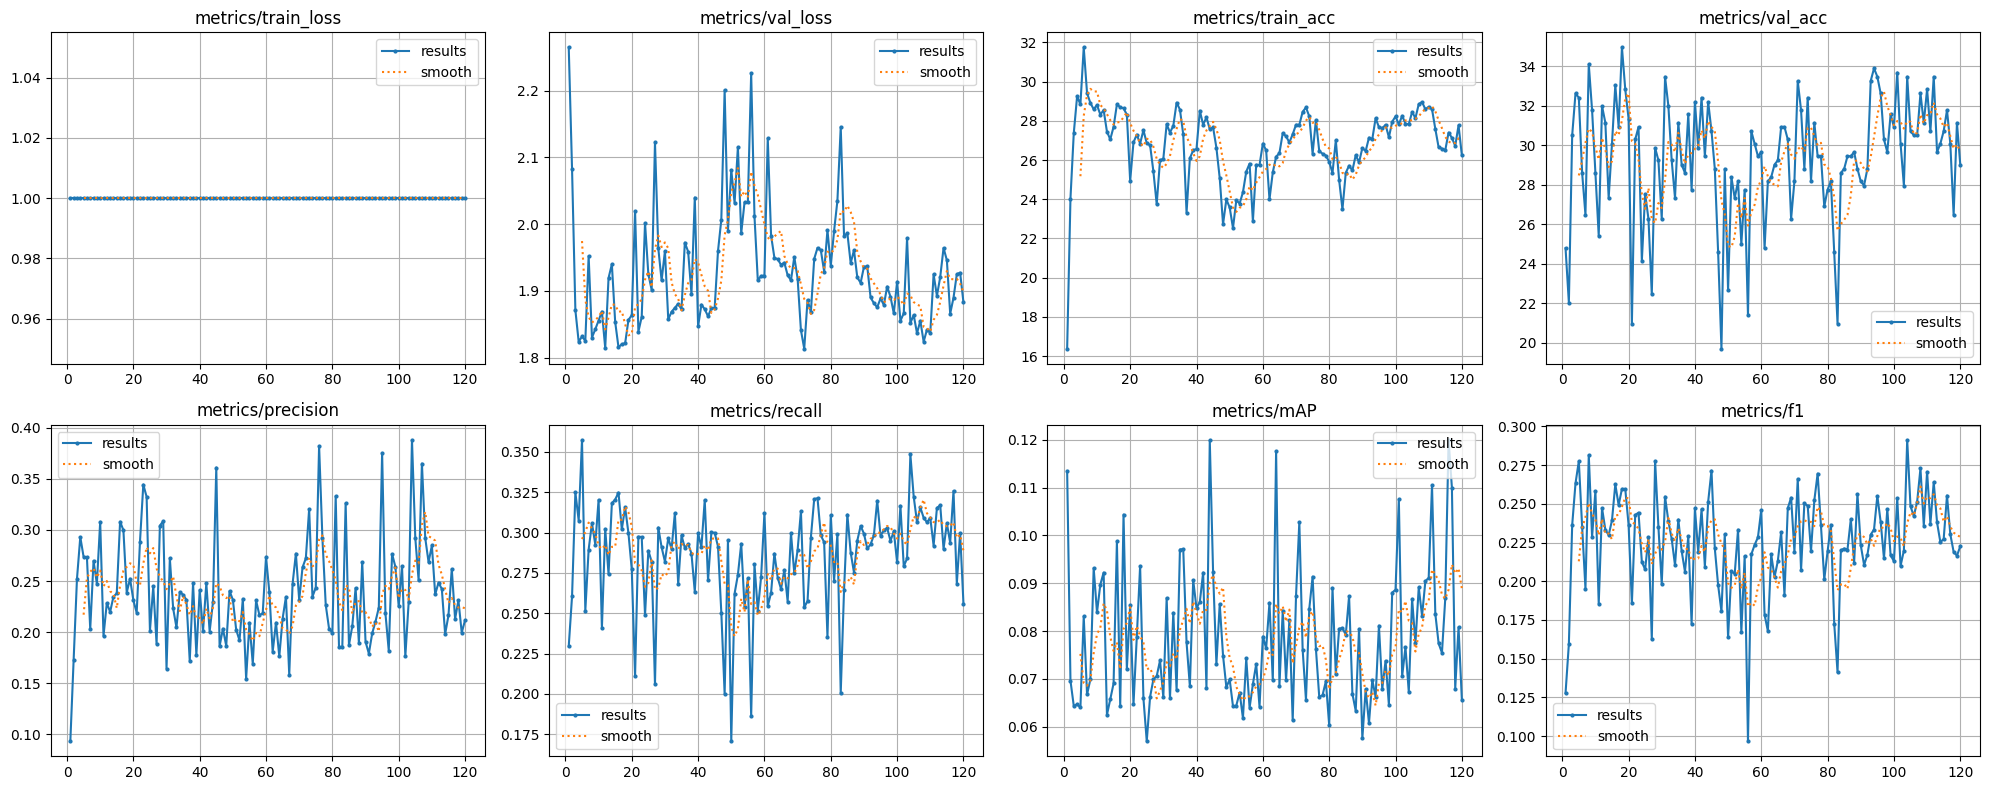

In [3]:


# Load the results.csv file
results_df = pd.read_csv('metrics/metrics_results.csv')

# Strip any leading/trailing spaces in the column names
results_df.columns = results_df.columns.str.strip()

# Print the available columns to check for typos
print(results_df.columns)

# Assuming the correct column name is 'Train Loss' based on previous code
# Convert 'Train Loss' column to numeric, forcing errors to NaN
results_df['Train Loss'] = pd.to_numeric(results_df['Train Loss'], errors='coerce')

# Replace inf and NaN values with the median of the column
median_value = results_df['Train Loss'].median()
results_df['Train Loss'] = results_df['Train Loss'].replace([np.inf, -np.inf], np.nan)
results_df['Train Loss'].fillna(median_value, inplace=True)

# Now, you can safely clip the values if needed
results_df['Train Loss'] = results_df['Train Loss'].clip(upper=1.0)

# Define a smoothing function using a rolling window
def smooth(data, window_size=5):
    return data.rolling(window=window_size).mean()

# Extract columns and apply smoothing to relevant metrics
epochs = results_df['Epoch']
train_loss = results_df['Train Loss']
val_loss = results_df['Val Loss']
train_acc = results_df['Train Accuracy']
val_acc = results_df['Val Accuracy']
precision = results_df['Precision']
recall = results_df['Recall']
map = results_df['mAP']
f1= results_df['F1 Score']

# Apply smoothing to some metrics
smoothed_train_loss = smooth(train_loss)
smoothed_val_loss = smooth(val_loss)
smoothed_train_acc = smooth(train_acc)
smoothed_val_acc = smooth(val_acc)
smoothed_precision = smooth(precision)
smoothed_recall = smooth(recall)
smoothed_map = smooth(map)
smoothed_f1 = smooth(f1)

# Create the plot
fig, axs = plt.subplots(2, 4, figsize=(20, 8))

# First row: Training losses and precision/recall
axs[0, 0].plot(epochs, train_loss, label='results', marker='o', markersize=2)
axs[0, 0].plot(epochs, smoothed_train_loss, label='smooth', linestyle='dotted')
axs[0, 0].set_title('metrics/train_loss')

axs[0, 1].plot(epochs, val_loss, label='results', marker='o', markersize=2)
axs[0, 1].plot(epochs, smoothed_val_loss, label='smooth', linestyle='dotted')
axs[0, 1].set_title('metrics/val_loss')

axs[0, 2].plot(epochs, train_acc, label='results', marker='o', markersize=2)
axs[0, 2].plot(epochs, smoothed_train_acc, label='smooth', linestyle='dotted')
axs[0, 2].set_title('metrics/train_acc')

axs[0, 3].plot(epochs, val_acc, label='results', marker='o', markersize=2)
axs[0, 3].plot(epochs, smoothed_val_acc, label='smooth', linestyle='dotted')
axs[0, 3].set_title('metrics/val_acc')

# Second row: Validation losses and mAP metrics
axs[1, 0].plot(epochs, precision, label='results', marker='o', markersize=2)
axs[1, 0].plot(epochs, smoothed_precision, label='smooth', linestyle='dotted')
axs[1, 0].set_title('metrics/precision')

axs[1, 1].plot(epochs, recall, label='results', marker='o', markersize=2)
axs[1, 1].plot(epochs, smoothed_recall, label='smooth', linestyle='dotted')
axs[1, 1].set_title('metrics/recall')

axs[1, 2].plot(epochs, map, label='results', marker='o', markersize=2)
axs[1, 2].plot(epochs, smoothed_map, label='smooth', linestyle='dotted')
axs[1, 2].set_title('metrics/mAP')

axs[1, 3].plot(epochs, f1, label='results', marker='o', markersize=2)
axs[1, 3].plot(epochs, smoothed_f1, label='smooth', linestyle='dotted')
axs[1, 3].set_title('metrics/f1')

# Add legends and grid
for ax in axs.flat:
    ax.legend()
    ax.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Save the plot as a PNG file
plt.savefig(f'{save_dir}/results_smoothed.png')

# Show the plot
plt.show()